# Core Features: Import

In [26]:
# libraries
import copy
import sys
import os
from typing import List
import time
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from torchinfo import summary
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]
%matplotlib inline

In [47]:
# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.metrics.metric import Metric
from loss_landscapes.model_interface.model_wrapper import ModelWrapper, wrap_model
from loss_landscapes.model_interface.model_parameters import ModelParameters, rand_u_like, rand_n_like, orthogonal_to
from loss_landscapes.contrib.functions import SimpleWarmupCaller, SimpleLossEvalCaller, log_refined_loss

In [3]:
from pyhessian.utils import *
from pyhessian import hessian, get_esd_plot, density_generate # ESD plot

In [4]:
from segmentationCRF import metrics
from segmentationCRF.models import UNet
from segmentationCRF.data_utils import get_datset, get_default_transforms
from segmentationCRF import test
from segmentationCRF.crfseg import CRF

## 1. Preliminary: Define Parameters

In [5]:
# Hyper-parameters
data_path = "/global/cfs/cdirs/m636/geshi/data/"
input_size = 224
batch_size=32
n_workers = 0
classes = ('foreground', 'background', 'border')
n_classes = len(classes)
num_epochs = 15

data_transform, target_transform = get_default_transforms('oxford', input_size, n_classes, noise_level=0)

In [6]:
# model architecture hyperparameters
downward_params = {
    'in_channels': 3, 
    'emb_sizes': [32, 64, 128, 256, 512], 
    'out_channels': [32, 64, 128, 256, 512],
    'kernel_sizes': [3, 3, 3 ,3 ,3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False,
}
upward_params = {
    'in_channels': [512, 1024, 512, 256, 128],
    'emb_sizes': [1024, 512, 256, 128, 64], 
    'out_channels': [512, 256, 128, 64, 32],
    'kernel_sizes': [3, 3, 3, 3, 3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False, 
    'bilinear': True,
}
output_params = {
    'in_channels': 64,
    'n_classes': n_classes,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# contour plot resolution
STEPS = 20
RANDOM = 'normal'
NORM = 'layer'
DIST = 0.1
MODEL_DIR = '/global/cfs/cdirs/m636/geshi/exp/Oxford/crf/CrossEntropy/0_seed_9999'
trained_on = MODEL_DIR.split('/')[-2]
seed = (int)(MODEL_DIR.split('/')[-1].split('_')[-1])
use_hessian = True

In [8]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
dataset_parameters = {
    'data_path': data_path,
    'split': 'trainval',
    'data_transform': data_transform,
    'target_transform': target_transform,
    'download': True,
}

val_dataset_parameters = {
    'data_path': data_path,
    'split': 'test',
    'data_transform': data_transform,
    'target_transform': target_transform,
    'download': True,
}

dataset = get_datset('oxford', dataset_parameters)
val_dataset = get_datset('oxford', val_dataset_parameters)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

## 2. Model construction and evaluation

In [10]:
x = torch.rand(1, 3, input_size, input_size)
unet = UNet(downward_params, upward_params, output_params)
model = nn.Sequential(
    unet,
    CRF(n_spatial_dims=2)
)
out = model(x)
print('output shape', out.shape)

output shape torch.Size([1, 3, 224, 224])


In [11]:
model = model.to(device)
model.eval()
# stores the initial point in parameter space
model_initial = copy.deepcopy(model)

In [12]:
# define the comparison function to sort
def srotFunc(e):
    return int(e.split('-')[0].split('iter')[1])

In [13]:
# define settings to try
try_models = []
for name in os.listdir(MODEL_DIR):
    if name.endswith('.pt'):
        try_models.append(name)
try_models.sort(key=srotFunc, reverse=True)
print(try_models)

['iter1024-10-16-2023-17:17:24.pt', 'iter512-10-16-2023-17:13:04.pt', 'iter256-10-16-2023-17:10:51.pt', 'iter128-10-16-2023-17:09:39.pt', 'iter64-10-16-2023-17:08:33.pt', 'iter32-10-16-2023-17:07:56.pt', 'iter16-10-16-2023-17:07:36.pt', 'iter8-10-16-2023-17:07:26.pt', 'iter4-10-16-2023-17:07:21.pt', 'iter2-10-16-2023-17:07:18.pt', 'iter1-10-16-2023-17:07:16.pt', 'iter0-10-16-2023-17:07:08.pt']


In [15]:
checkpoint = torch.load(os.path.join(MODEL_DIR, try_models[0]), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
test(model, val_dataloader, n_classes, device)

Test : 100%|██████████| 115/115 [04:39<00:00,  2.43s/batch, accuracy=85.8]

Testing complete in 4m 39s, Test Acc: 85.77689552671028, Test Iou: 0.6929683983781852


(array([0.8065092 , 0.81356496, 0.45883103]),
 {'test_acc': 85.77689552671028,
  'test_homogeneity': 0.03801889281794043,
  'test_frequency_weighted_IOU': 0.7555984373971956,
  'test_mean_IOU': 0.6929683983781852})

In [16]:
criterion = torch.nn.CrossEntropyLoss() # DiceLoss(True), IOULoss(softmax=True)
model_final = copy.deepcopy(model)

In [17]:
x, y = iter(dataloader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.to(device), y.to(device))

## 3. UNet-CRF 2D Loss Landscape

In [29]:
# compute loss data
pll = loss_landscapes.PlanarLossLandscape(model_final, STEPS, deepcopy_model=True)
pll.random_plain(distance=DIST, normalization=NORM, centered=True)
pll.stats_initializer()

In [30]:
# single batch loss landscape
since = time.time()
pll.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data = pll.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  44.55355978012085
compute time cost  42.33216857910156


In [31]:
# loss_data_fin = log_refined_loss(loss_data)
loss_data_fin = loss_data

The loss values on this plane can be visualized in an intuitive and interpretable manner using contour plots or 3D surface plots:

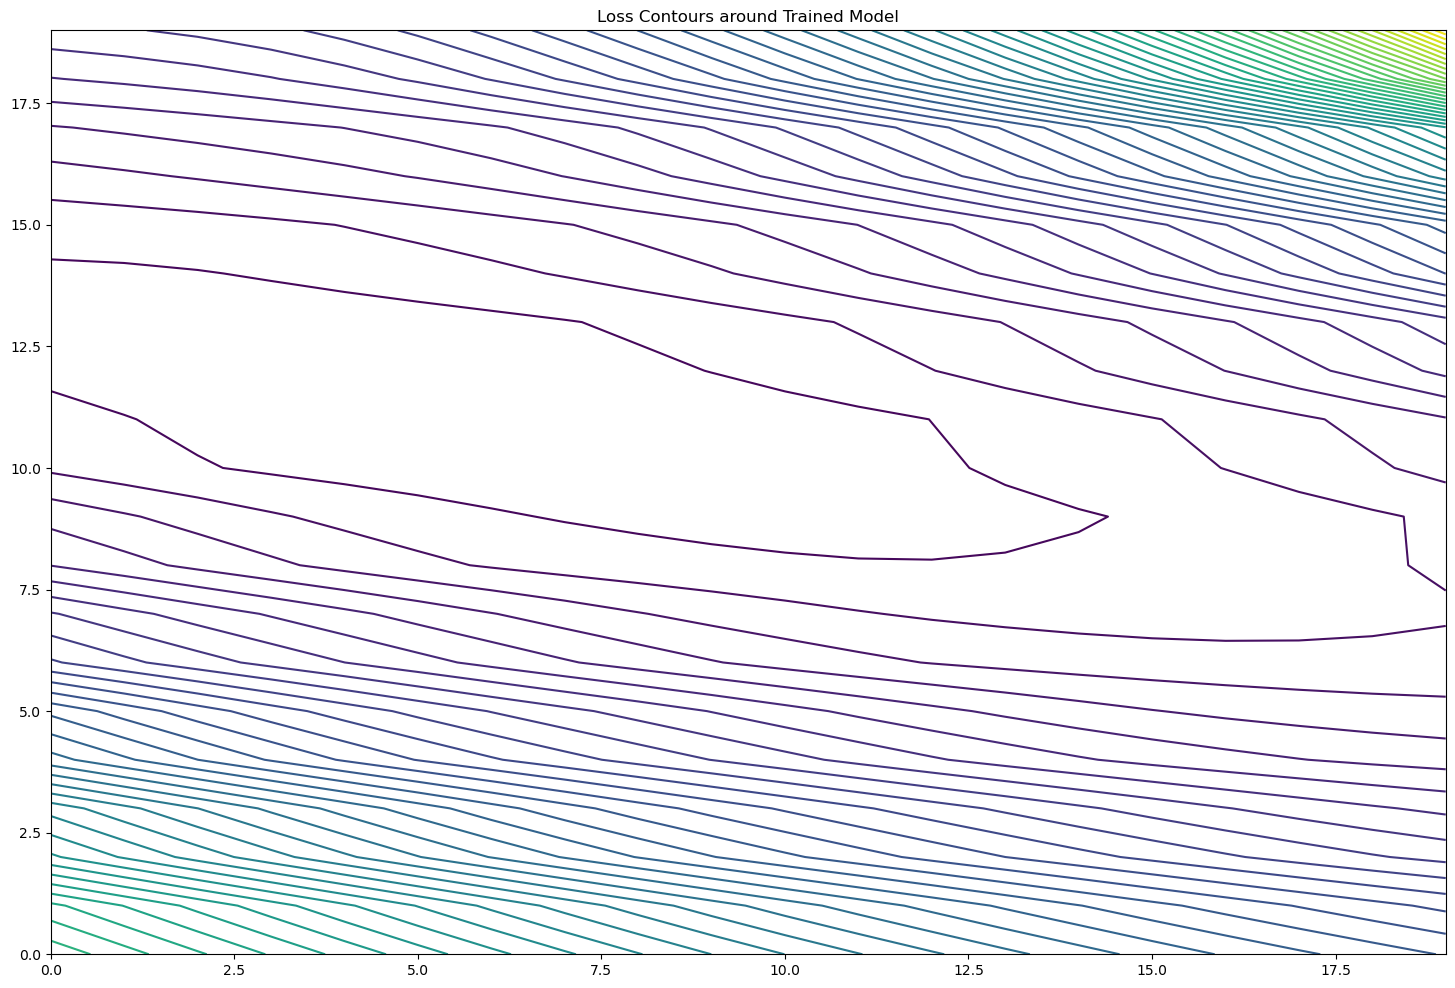

In [32]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

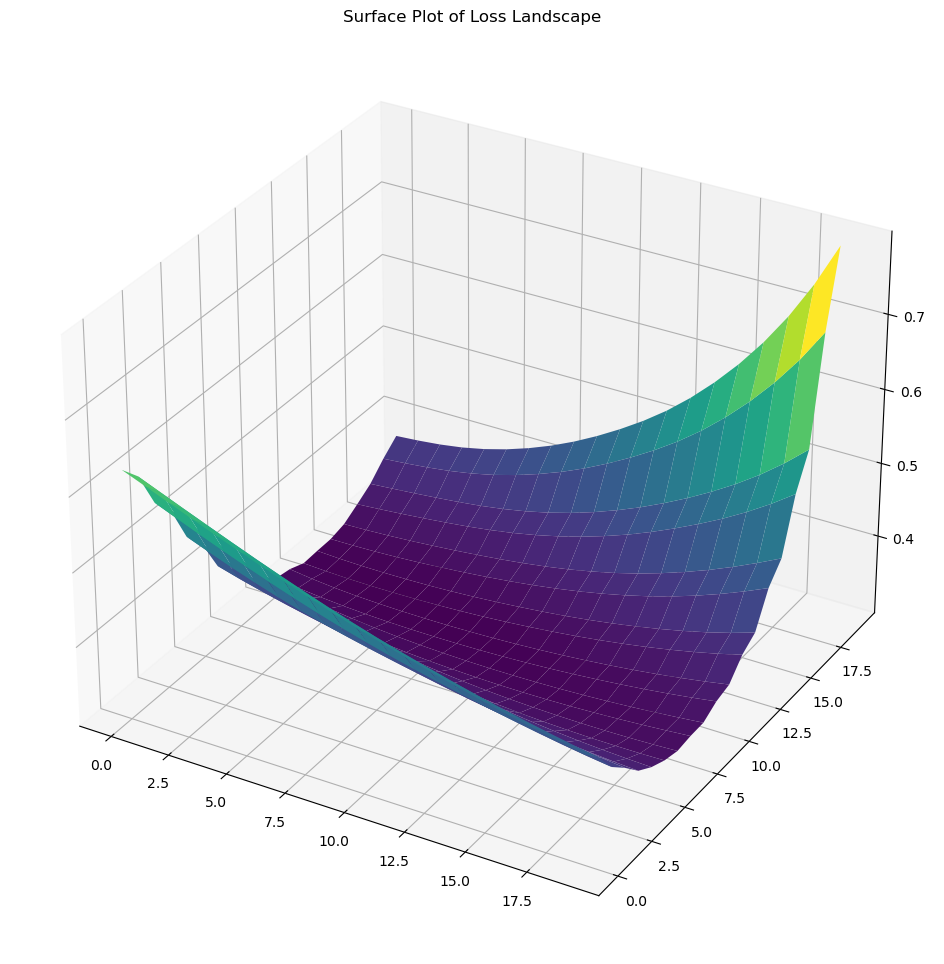

In [33]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

## 4 UNet 2D loss landscape

In [39]:
unet_final = model_final[0]
crf_final = model_final[1]

In [41]:
# single batch loss landscape
since = time.time()
pll_unet.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_unet = pll_unet.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  13.585750579833984
compute time cost  11.442054748535156


In [41]:
# single batch loss landscape
since = time.time()
pll_unet.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_unet = pll_unet.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  13.585750579833984
compute time cost  11.442054748535156


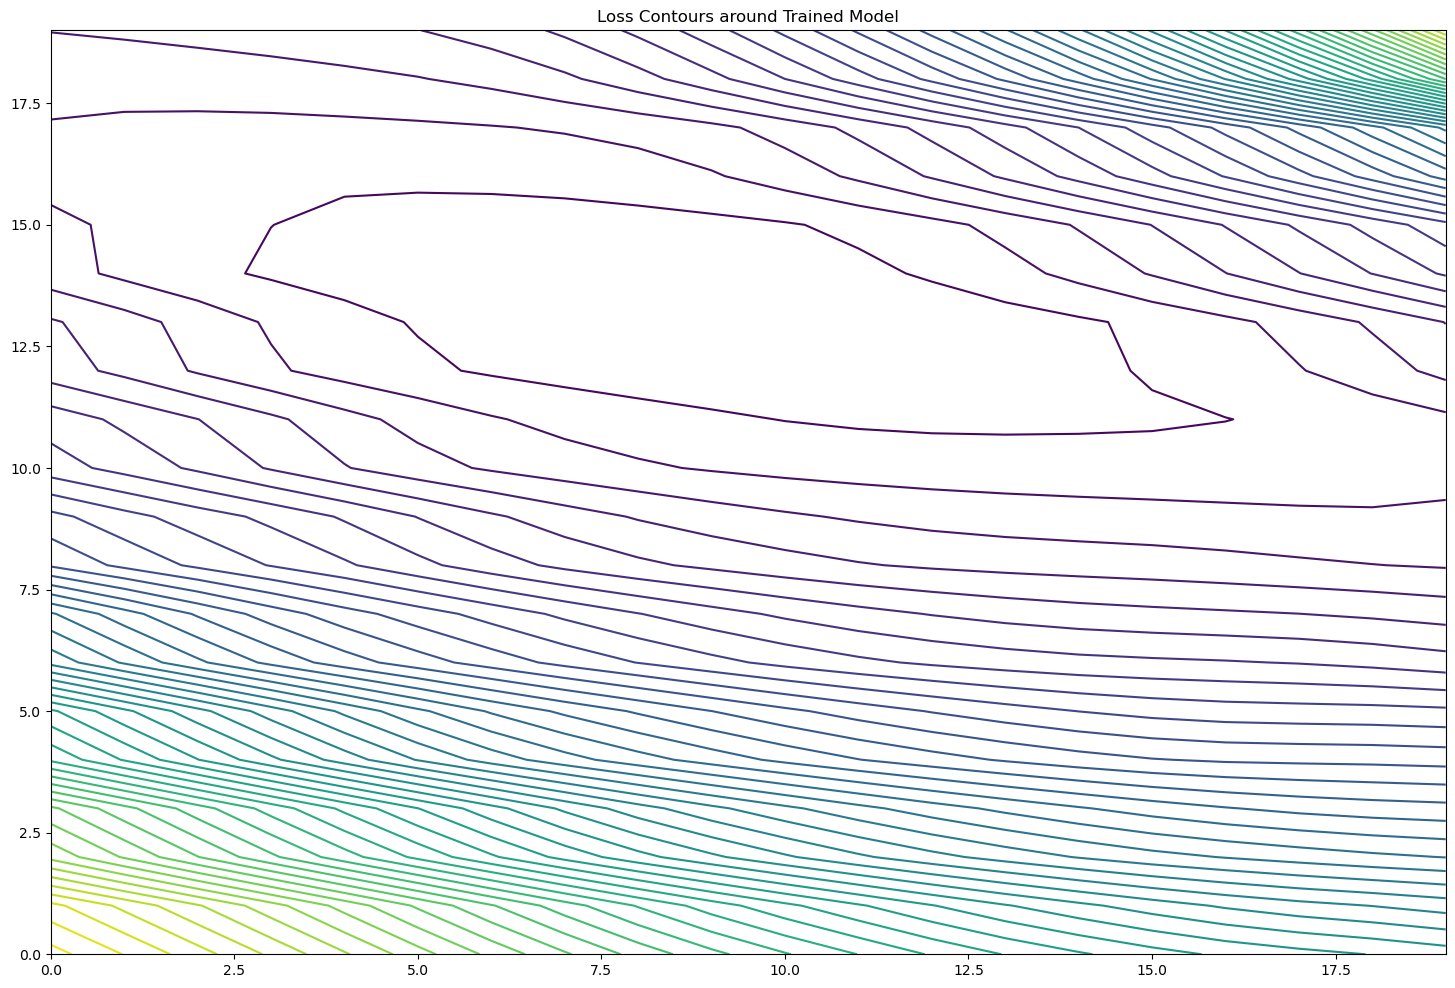

In [42]:
plt.contour(loss_data_unet, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

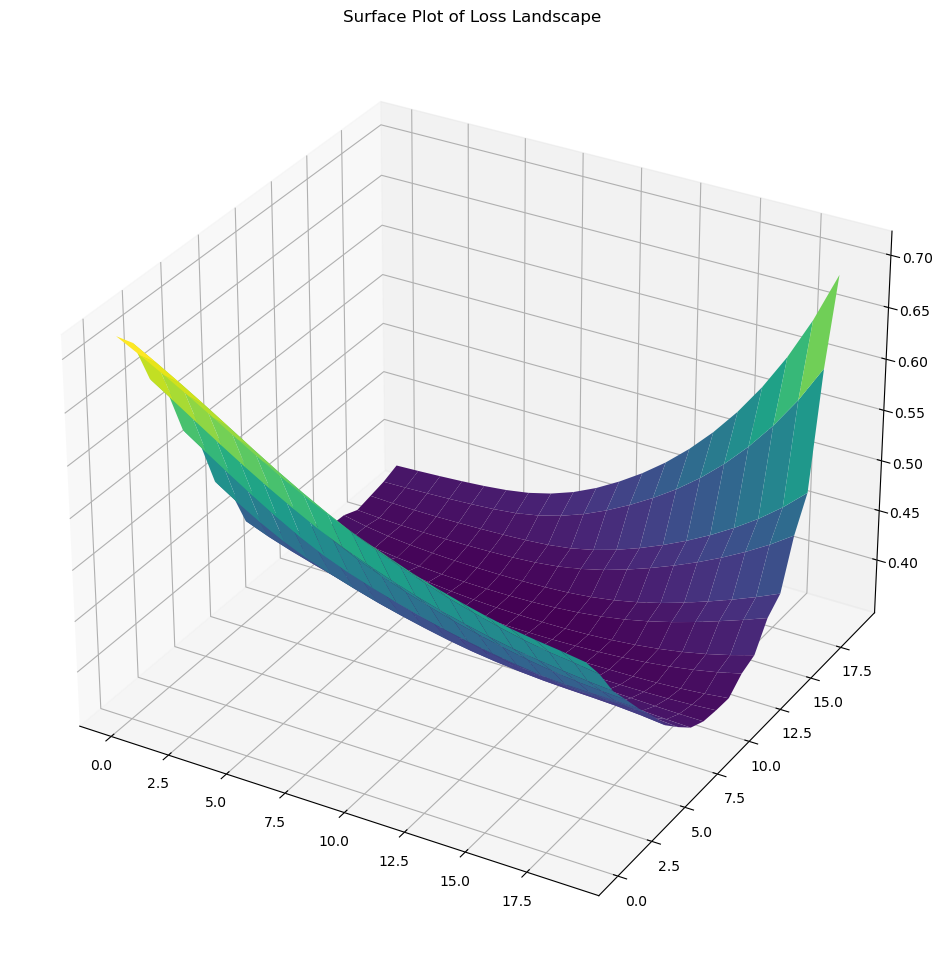

In [43]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_unet, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

## 5. 4 - 3

In [44]:
loss_data_diff = loss_data_fin - loss_data_unet

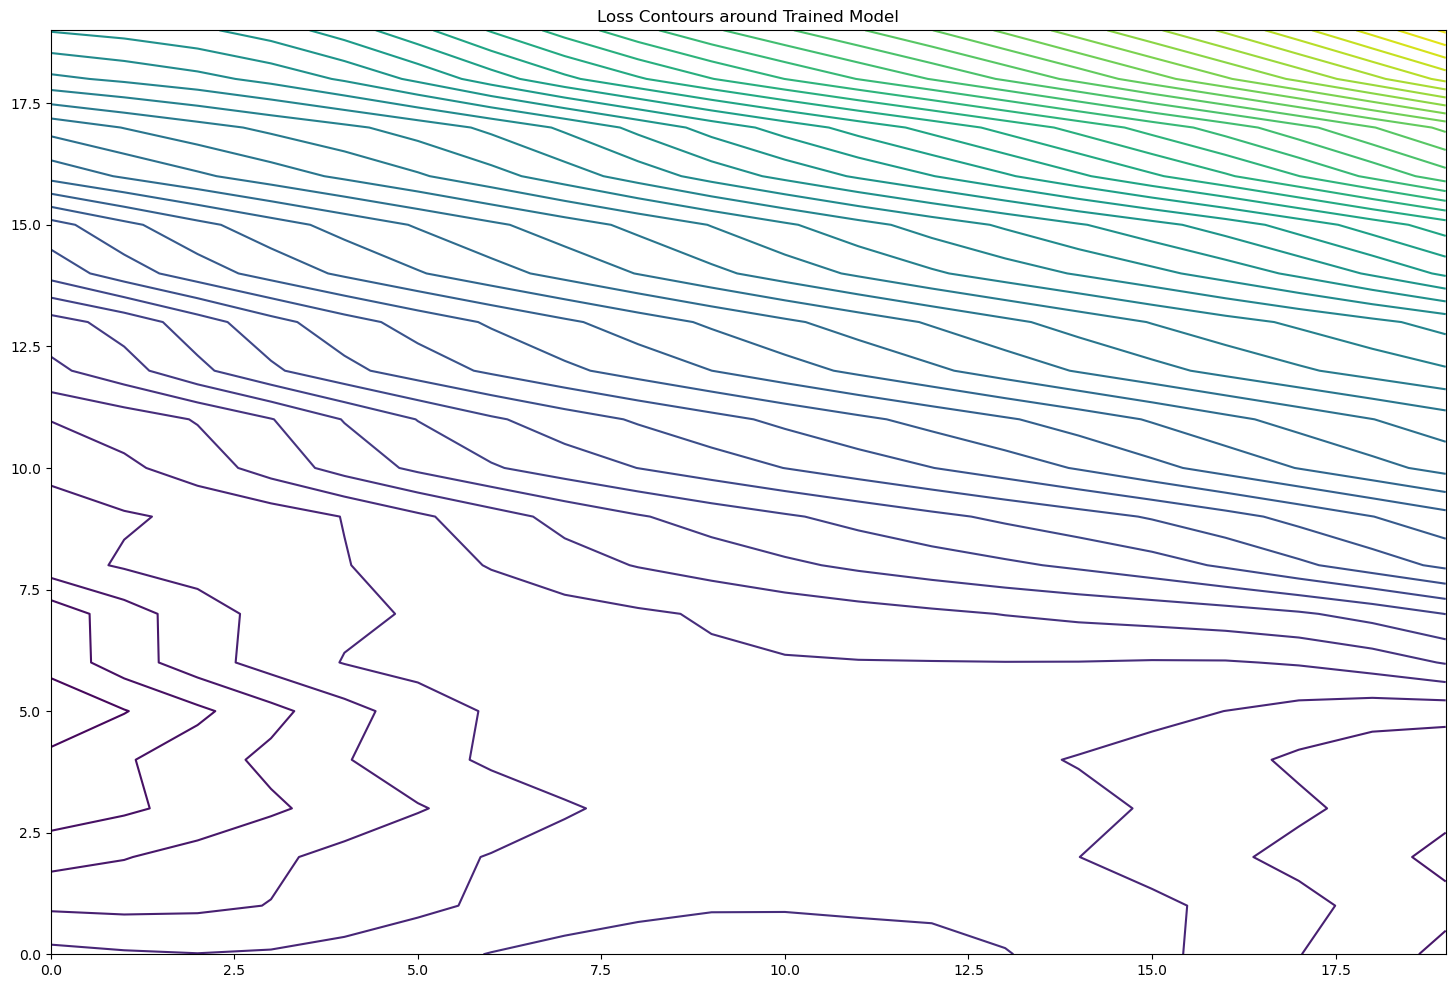

In [45]:
plt.contour(loss_data_diff, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

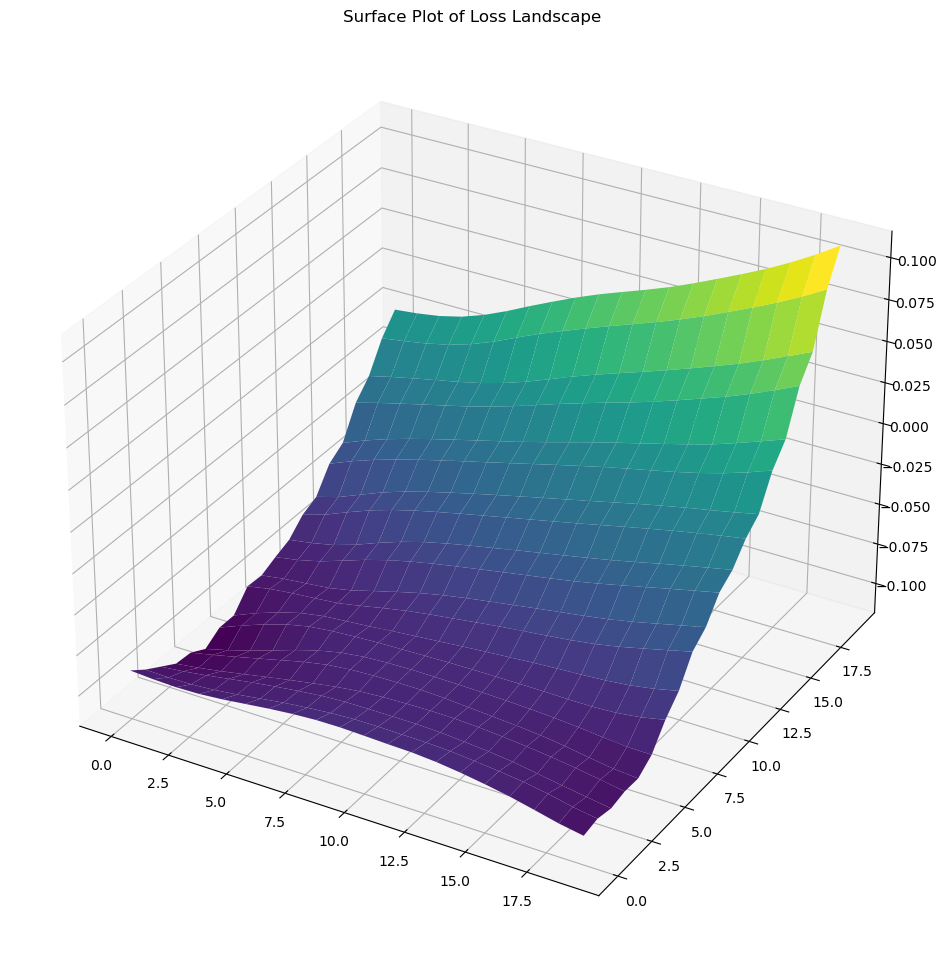

In [46]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_diff, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

## 6. Perturb CRF Only

In [49]:
class CRFPerturbLoss(Metric):
    """ Computes a specified loss function over specified input-output pairs, using a backbone network and only perturb CRF."""
    def __init__(self, backbone, loss_fn, inputs: torch.Tensor, target: torch.Tensor):
        super().__init__()
        self.backbone = backbone
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.target = target

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        self.backbone.eval()
        with torch.no_grad():
            intermediate = self.backbone.forward(self.inputs)
        return self.loss_fn(model_wrapper.forward(intermediate), self.target).item()

In [51]:
crf_metric = CRFPerturbLoss(unet_final, criterion, x.to(device), y.to(device))

In [52]:
# compute loss data
pll_crf_only = loss_landscapes.PlanarLossLandscape(crf_final, STEPS, deepcopy_model=True)
pll_crf_only.random_plain(distance=DIST, normalization=NORM, centered=True)
pll_crf_only.stats_initializer()

In [53]:
# single batch loss landscape
since = time.time()
pll_crf_only.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_crf_only = pll_crf_only.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  32.78411078453064
compute time cost  32.43239665031433


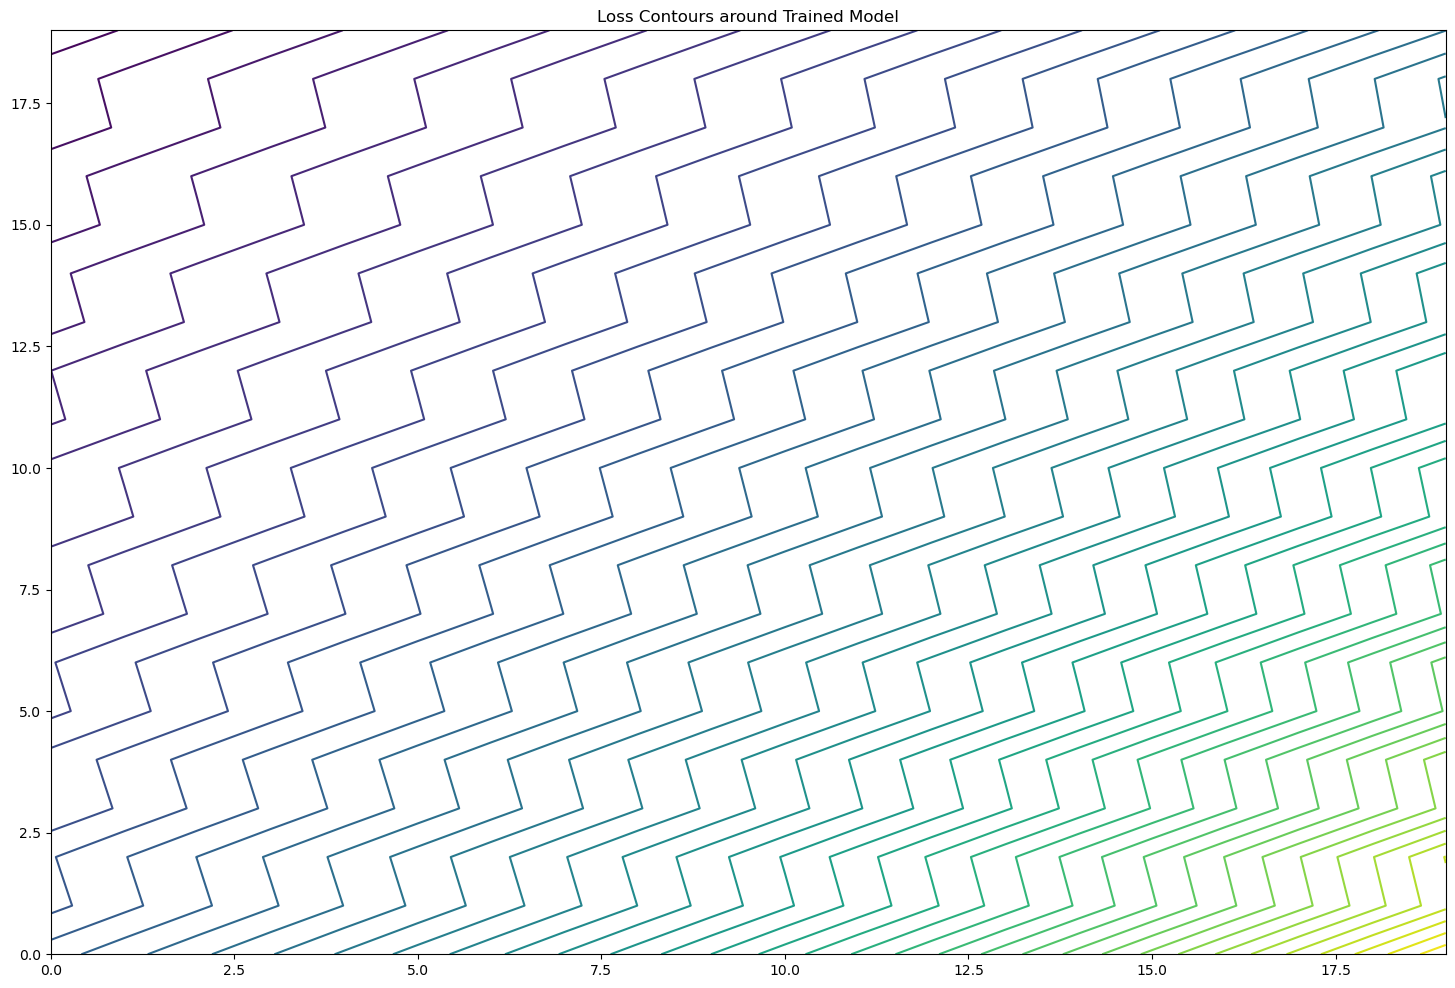

In [54]:
plt.contour(loss_data_crf_only, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

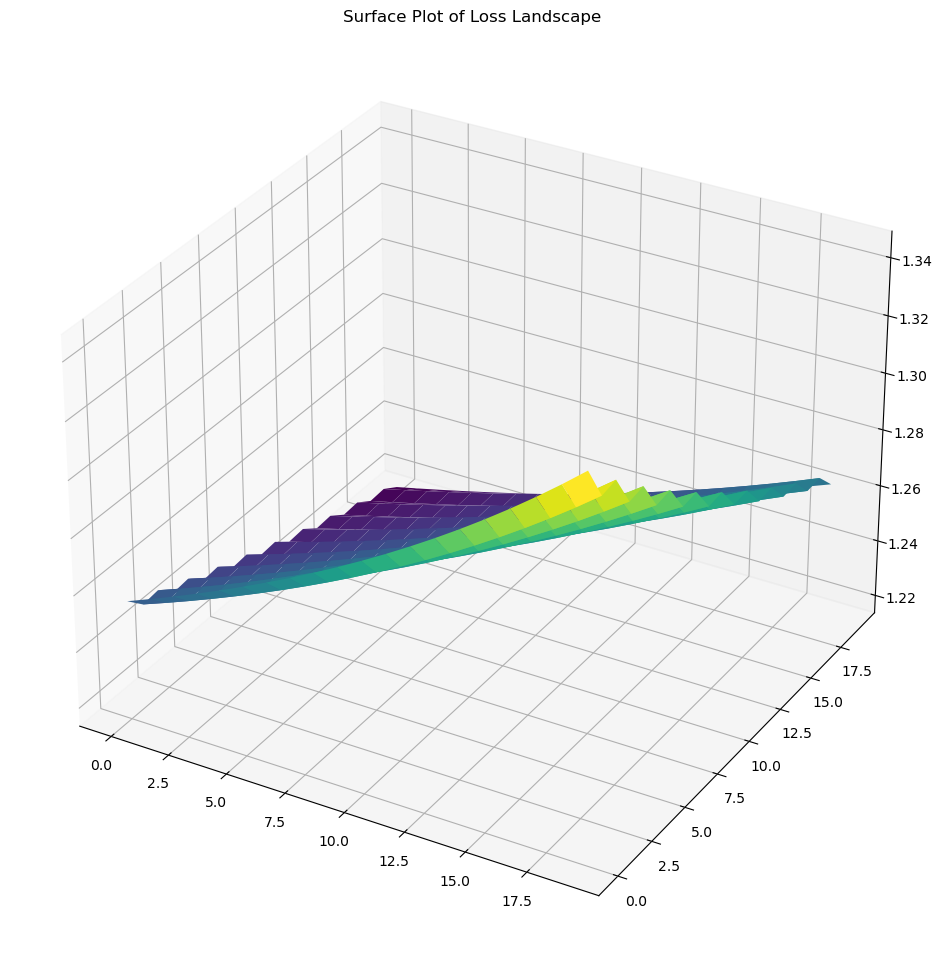

In [55]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_crf_only, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

## 7. Perturb UNet Only

In [58]:
class BackbonePerturbLoss(Metric):
    """ Computes a specified loss function over specified input-output pairs, using a backbone network and only perturb CRF."""
    def __init__(self, crf, loss_fn, inputs: torch.Tensor, target: torch.Tensor):
        super().__init__()
        self.crf = crf
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.target = target

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        intermediate = model_wrapper.forward(intermediate)
        self.crf.eval()
        with torch.no_grad():
            loss = self.loss_fn(self.crf.forward(intermediate), self.target).item()
        return loss

In [59]:
unet_metric = BackbonePerturbLoss(crf_final, criterion, x.to(device), y.to(device))

In [60]:
# compute loss data
pll_unet_only = loss_landscapes.PlanarLossLandscape(unet_final, STEPS, deepcopy_model=True)
pll_unet_only.random_plain(distance=DIST, normalization=NORM, centered=True)
pll_unet_only.stats_initializer()

In [61]:
# single batch loss landscape
since = time.time()
pll_unet_only.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_unet_only = pll_unet_only.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  13.552591323852539
compute time cost  11.422629594802856


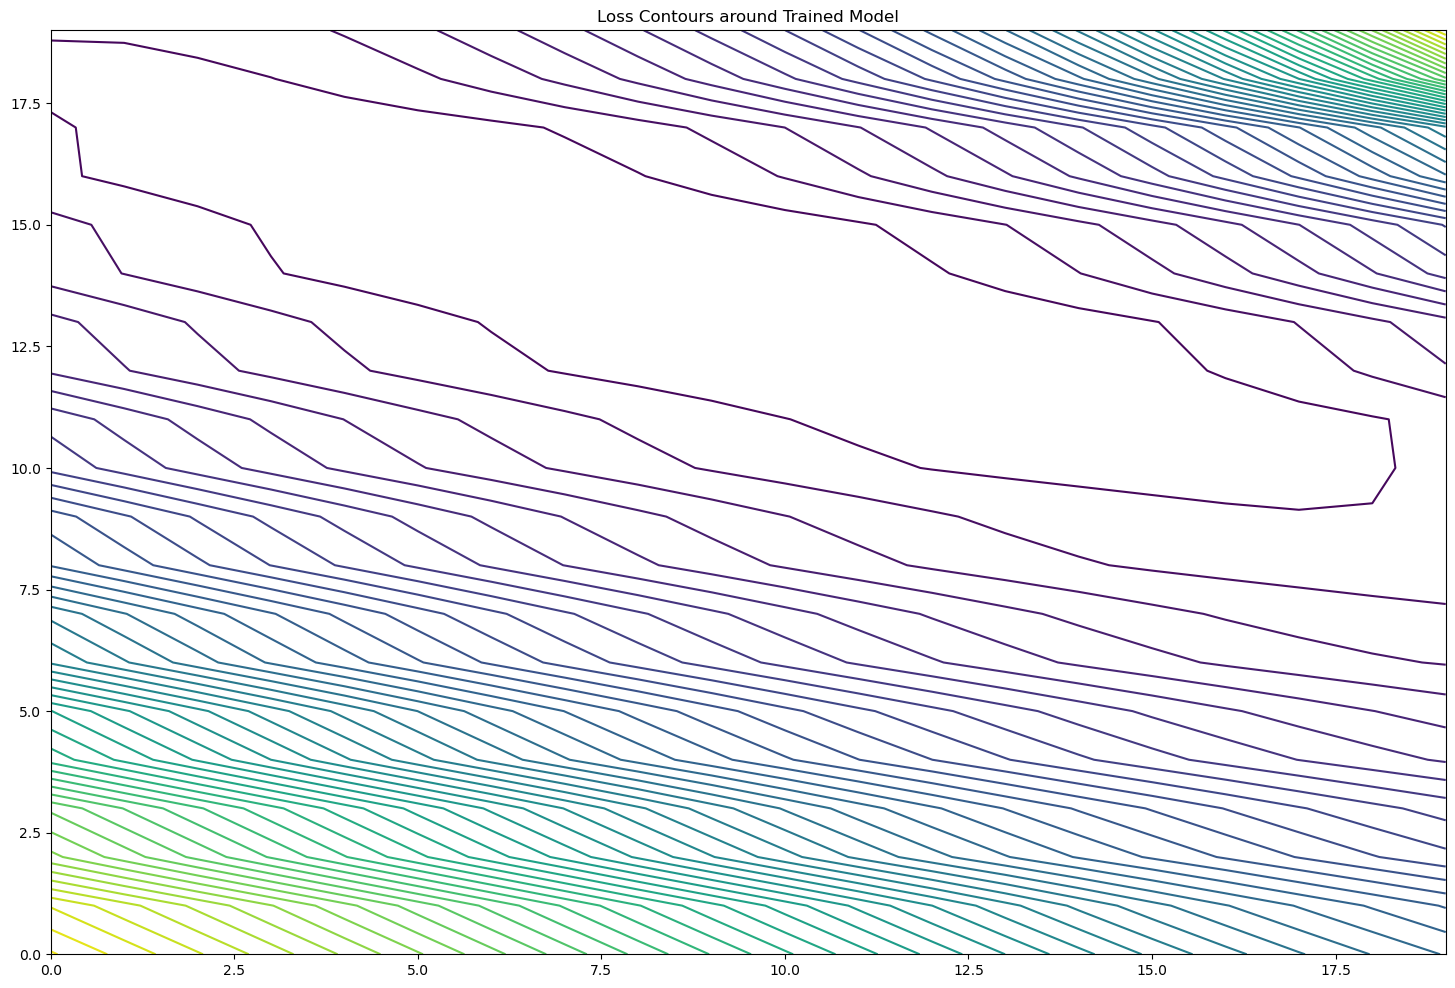

In [62]:
plt.contour(loss_data_unet_only, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

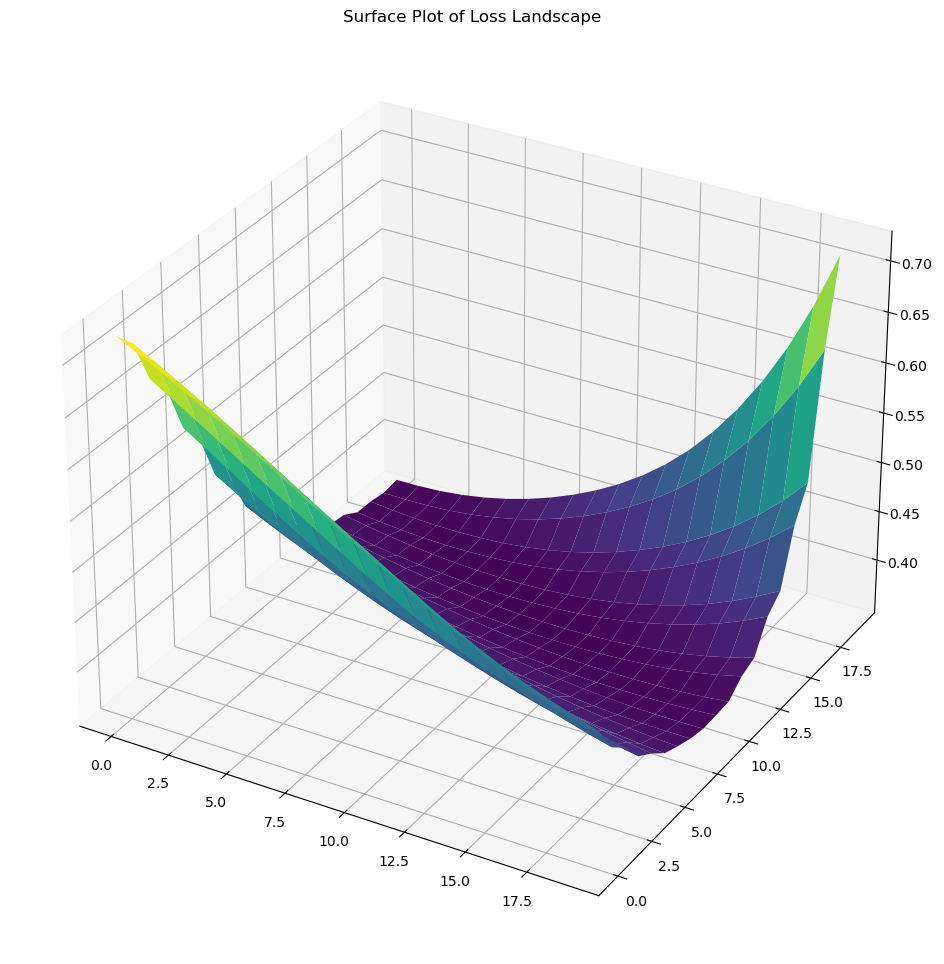

In [63]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_unet_only, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()